In [1]:
# boiler plate to allow running in colab, can ignore if running locally
import subprocess
try:
    import tailnflows
except ModuleNotFoundError:
    # need to build environment
    print('installing tailnflows environment...')
    subprocess.run(['pip', 'install', 'git+https://github.com/Tennessee-Wallaceh/tailnflows'])
    import tailnflows
    from tailnflows.utils import configure_colab_env
    configure_colab_env() # can take a while
    import torch
    torch.set_default_device('cuda')

installing tailnflows environment...
b"  Running command git clone --filter=blob:none --quiet https://github.com/Tennessee-Wallaceh/nflows /tmp/pip-req-build-dy238t63\n  Encountered 2 file(s) that should have been pointers, but weren't:\n        examples/conditional_moons.ipynb\n        examples/moons.ipynb\n"
b'  Running command git clone --filter=blob:none --quiet https://github.com/Tennessee-Wallaceh/marginalTailAdaptiveFlow.git /tmp/pip-req-build-i64237wu\n'
Setup complete!


In [ ]:
import torch
torch.set_default_device('cuda')
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import seaborn as sns
import tailnflows
import nflows

In [2]:
from tailnflows.utils import get_project_root

def shift_loader(dim, df, repeat):
  file_name = f'{get_project_root()}/data/synthetic/alt_shift_new/dim-{dim}_v-{str(df).replace(".",",")}_repeat-{repeat}.p'
  try:
    dataset = torch.load(file_name)
  except FileNotFoundError:
    print(f'No file with that configuration, either sync or generate. ({file_name})')
    return None

  return dataset

In [3]:
from tailnflows.models.extreme_transformations import TailMarginalTransform, flip
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform, MaskedPiecewiseRationalQuadraticAutoregressiveTransform
from nflows.flows import Flow
from nflows.transforms.base import CompositeTransform
from nflows.transforms.nonlinearities import Logit
from nflows.distributions.normal import StandardNormal
from tailnflows.models.base_distribution import TrainableStudentT, NormalStudentTJoint, GeneralisedNormal, NormalMixture
from tailnflows.models.comet_models.comet_models import MarginalLayer as COMETMarginalLayer
from tailnflows.models.flows import TTF, TTF_m, gTAF, mTAF, RQS, COMET
from tailnflows.models.flows import get_model, ModelName, ModelUse

def build_gennormal(dim, dfs, x_trn):
  flow = RQS(
      dim,
      ModelUse.density_estimation,
      model_kwargs=dict(
        tail_bound=5.,
        rotation=False,
        num_bins=8,
      ),
  )
  flow._distribution = GeneralisedNormal(dim)
  return flow

def build_mixnormal(dim, dfs, x_trn):
  flow = RQS(
      dim,
      ModelUse.density_estimation,
      model_kwargs=dict(
        tail_bound=5.,
        rotation=False,
        num_bins=8,
      ),
  )
  flow._distribution = NormalMixture(dim, 10)
  return flow

def df_to_switch_tailp(dfs):
  return torch.tensor([
      1 / df if df > 0 else -1
      for df in dfs
  ])

def df_to_tailp(dfs):
  return torch.tensor([
      1 / df if df > 0 else 1e-3
      for df in dfs
  ])

models = {
    'normal': (
        lambda dim, dfs, x_trn: RQS(
            dim,
            ModelUse.density_estimation,
            model_kwargs=dict(
              tail_bound=5.,
              rotation=False,
              num_bins=8,
            ),
        ),
        dict(lr=5e-3, num_epochs=250, lrschedule=False)
    ),
    'g_normal': (
        build_gennormal,
        dict(lr=5e-3, num_epochs=500, lrschedule=False),
    ),
    'm_normal': (
        build_mixnormal,
        dict(lr=5e-3, num_epochs=500, lrschedule=False),
    ),
    'gTAF': (
        lambda dim, dfs, x_trn: gTAF(
            dim,
            ModelUse.density_estimation,
            model_kwargs=dict(
                tail_bound=5.,
                rotation=False,
                num_bins=8
            )
        ),
        dict(lr=5e-3, num_epochs=500, lrschedule=False),
    ),
    'mTAF': (
        lambda dim, dfs, x_trn: mTAF(
            dim,
            ModelUse.density_estimation,
            model_kwargs=dict(
                tail_bound=5.,
                rotation=False,
                tail_init=torch.tensor(dfs),
                num_bins=8
            )
        ),
        dict(lr=5e-3, num_epochs=500, lrschedule=False),
    ),
    'comet': (
        lambda dim, dfs, x_trn: COMET(
            dim,
            x_trn,
            ModelUse.density_estimation,
            model_kwargs=dict(
              tail_bound=5.,
              rotation=False,
              num_bins=8,
              fix_tails=True,
              tail_init=dfs
            ),
        ),
        dict(lr=5e-3, num_epochs=400, lrschedule=False),
    ),
}

In [5]:
import datetime
from tailnflows.experiments.utils import add_raw_data
from tailnflows.train.data_fit import train

suspect_losses = []
target_dims = [5, 10, 50]
nuisance_dfs = [0.5, 1., 2., 30.]

experiment_path = 'synthetic_de_output'

# run fit
for repeat in range(5):
  print(f'Started repeat {repeat} @ {datetime.datetime.now()}')
  for dim in target_dims:
    for nuisance_df in nuisance_dfs:
        print('=' * 20, f'v={nuisance_df}, dim={dim}', '=' * 20)

        # load data
        dataset = shift_loader(dim, nuisance_df, repeat)
        assert dataset is not None
        dfs = [dataset['metadata']['nuisance_df']] * dim # for shift data set all dfs are the same
        x_trn = dataset['data'][dataset['split']['trn']].to('cuda').to(torch.float32)
        x_val = dataset['data'][dataset['split']['val']].to('cuda').to(torch.float32)
        x_tst = dataset['data'][dataset['split']['tst']].to('cuda').to(torch.float32)

        for label, (model_fcn, opt_p) in models.items():
            if label == 'comet':
              torch.set_default_device('cpu')
              if dim > 20:
                continue

            if label == 'comet': # comet only working on cpu
              model = model_fcn(dim, dfs, x_trn).to('cpu')
              x_trn = x_trn.to('cpu')
              x_val = x_val.to('cpu')
              x_tst = x_tst.to('cpu')
            else:
              model = model_fcn(dim, dfs, x_trn).to('cuda').to(torch.float32)

            n_epoch = opt_p.get('num_epochs', 300)
            fit_data = train(
              model,
              x_trn, x_val, x_tst,
              lr=opt_p.get('lr', 1e-3),
              num_epochs=n_epoch,
              batch_size=opt_p.get('batch_size', int(x_trn.shape[0] / 3)),
              label=label,
              lrschedule=opt_p.get('lrschedule', False)
            )
            if fit_data[1] > n_epoch * 0.95: # try to detect non-convergence
              suspect_losses.append((fit_data, (label, repeat, dim, nuisance_df)))

            add_raw_data(experiment_path, label, (fit_data[0].cpu().numpy(), dim, nuisance_df))

Started repeat 0 @ 2024-04-22 09:51:22.752912
==================== v=0.5, dim=5 ====================


MessageError: Error: credential propagation was unsuccessful

8


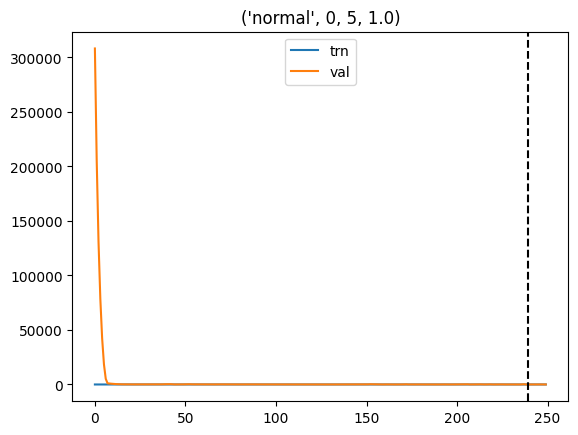

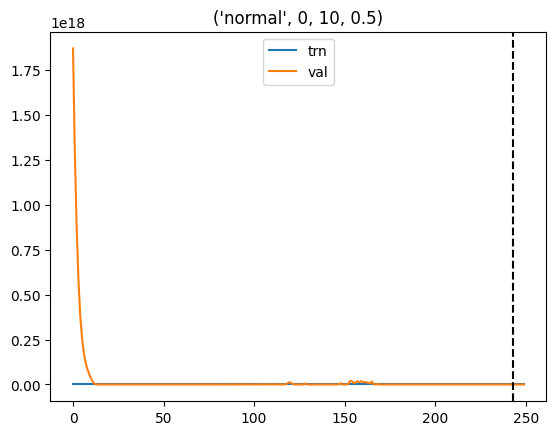

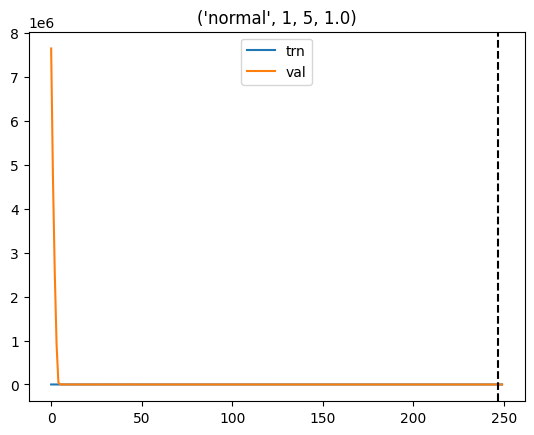

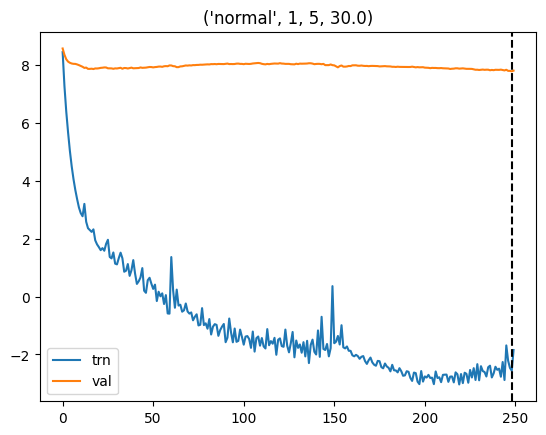

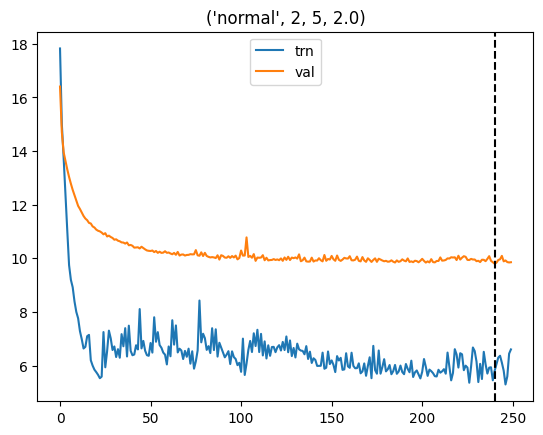

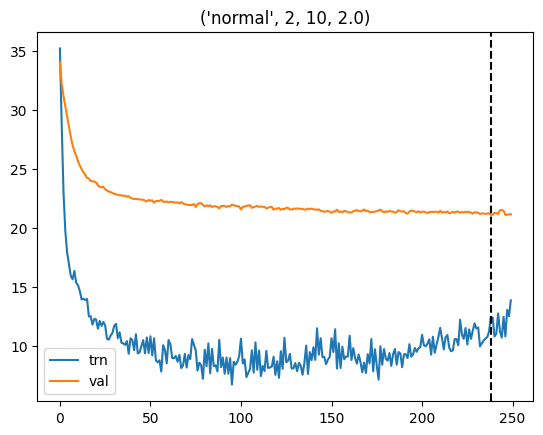

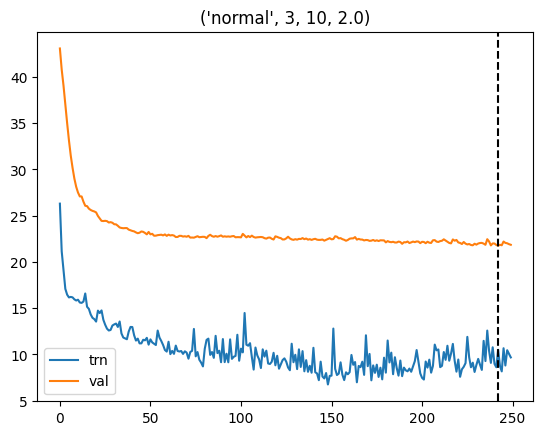

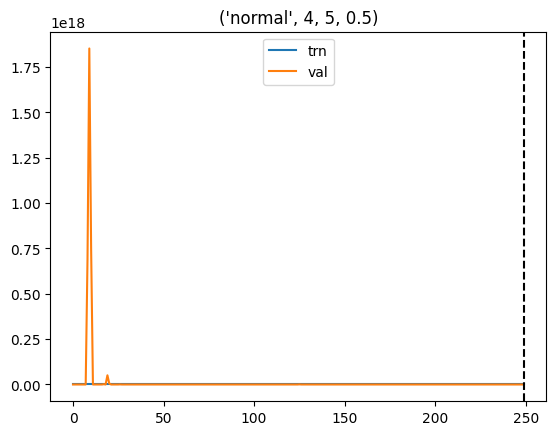

In [ ]:
print(len(suspect_losses))

for sl, meta in suspect_losses:
  tst_loss, tst_ix, losses, vlosses, hook = sl
  plt.title(meta)
  plt.plot(losses, label='trn')
  plt.plot(vlosses, label='val')
  plt.axvline(tst_ix, c='black', linestyle='--')
  plt.legend()
  plt.show()

In [ ]:
import pandas as pd
from tailnflows.experiments.utils import load_raw_data

experiment_path =
saved_metrics = load_raw_data(experiment_path)
rows = []
for label, (slice_start, final_metrics) in saved_metrics.items():
    for metric in final_metrics:
        rows.append({
            'model': label,
            'psis_k': float(metric.psis_k),
            'ess': float(metric.ess),
            'elbo': float(metric.elbo.cpu()),
        })

results_data = pd.DataFrame(rows)


import pandas as pd

raw_data = pickle.load( open(rd_path, "rb" ) )
proc_data = []
for label, fit_data in raw_data.items():
  for (test_ll, dim, df) in fit_data:
    # if label != 'normal_base':
    proc_data.append({'model': label, 'test_neg_ll': test_ll, 'dim': dim, 'df': df})

new_df = pd.DataFrame(proc_data)
new_df.test_neg_ll = new_df.test_neg_ll.astype('float')
new_df

,model,test_neg_ll,dim,df
0,TTF_m_fixed_noneg,16.080391,5,0.5
1,TTF_m_fixed_noneg,11.477255,5,1.0
2,TTF_m_fixed_noneg,9.317088,5,2.0
3,TTF_m_fixed_noneg,7.298553,5,30.0
4,TTF_m_fixed_noneg,34.432274,10,0.5
...,...,...,...,...
115,TTF_m_stable,14.605618,10,30.0
116,TTF_m_stable,181.763046,50,0.5
117,TTF_m_stable,125.711815,50,1.0
118,TTF_m_stable,97.964401,50,2.0
